# Bayesian sampler

gonna write this in python with pyro!

The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

In [186]:
%config IPCompleter.use_jedi = False
import torch
import pyro

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

torch.set_default_tensor_type(torch.DoubleTensor)

let's write down my thinking so far for the bayesian sampler and draw some samples!

In [187]:
def bsampler():
    beta = pyro.sample("beta", dist.HalfCauchy(1))
    N = pyro.sample("N", dist.HalfCauchy(5))
    theta = pyro.sample("theta", dist.Dirichlet(torch.ones(4)))
    x = torch.tensor([1.,1.,0.,0.]) # just at test
    p = torch.matmul(theta,x)
    
    pi = pyro.sample("pi", dist.Beta(p*N, p*N))
    y_hat = pyro.sample("y_hat", dist.Beta(beta + pi*N, beta + (1-pi)*N))
    return y_hat

<AxesSubplot:ylabel='Count'>

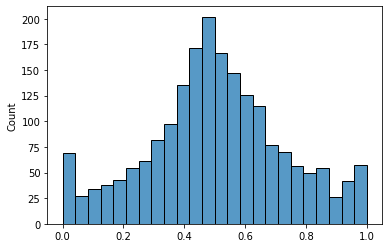

In [188]:
sns.histplot(np.array([bsampler() for _ in range(2000)]))

Holy COW! that was a lot easier than writing in Stan!

Ok now let's pull in the data.

In [189]:
## starting with just one P b/c I am struggling w/ python rustiness and filepaths
from dfply import *
import glob
import pandas as pd

df_raw = pd.read_csv("osfstorage-archive/Experiment 2/PrEstExp_001_111218_115935.csv")

df = (df_raw >> 
      group_by(X.querytype) >> 
      summarize(estimate = X.estimate.mean()) >>
      mutate(estimate = X.estimate/100.)
     )

test_df = df[df.querytype.isin(["A","B","AandB","AandnotB","notAandB","notAandnotB","notA","notB"])]

In [215]:
trials = list(test_df["querytype"])
observations = torch.tensor(test_df["estimate"].values)

test_data = {"trial":trials, "obs":observations}

trial_dict = dict({
    "AandB": torch.tensor([1.,0.,0.,0.]),
    "AandnotB": torch.tensor([0.,1.,0.,0.]),
    "notAandB": torch.tensor([0.,0.,1.,0.]),
    "notAandnotB": torch.tensor([0.,0.,0.,1.]),
    "A":torch.tensor([1.,1.,0.,0.]),
    "B":torch.tensor([1.,0.,1.,0.]),
    "notA":torch.tensor([0.,0.,1.,1.]),
    "notB":torch.tensor([0.,1.,0.,1.]),
    "AorB":torch.tensor([1.,1.,1.,0.]),
    "AornotB":torch.tensor([1.,1.,0.,1.]),
    "notAorB":torch.tensor([0.,1.,1.,1.]),
    "notAornotB":torch.tensor([0.,1.,0.,1.]),
})

## need to create a new dict for conditional probability trials
    
def bsampler(data):
    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    
    # need a theta per person/querytype
    theta = pyro.sample("theta", dist.Dirichlet(torch.ones(4)))

    # need pi and response per trial
    for i in range(len(data["trial"])):
        
        x = trial_dict[data["trial"][i]]
        p = torch.matmul(theta, x)
        pi = pyro.sample("pi_{}".format(i), dist.Beta(p*N, p*N))
        pyro.sample("yhat_{}".format(i), dist.Beta(beta + pi*N, beta + (1-pi)*N), obs=data["obs"][i])

# sns.histplot(np.array([bsampler(trial_dict["AorB"]) for _ in range(1000)]))

In [216]:
from pyro.infer.mcmc import NUTS, MCMC

# conditioned_model = pyro.condition(bsampler, data={"y_hat":observations[0]})

nuts_kernel = NUTS(bsampler, adapt_step_size=True)
py_mcmc = MCMC(nuts_kernel, num_samples=1_000, warmup_steps=500)

py_mcmc.run(test_data)

Sample: 100%|██████████| 1500/1500 [19:52,  1.26it/s, step size=2.40e-02, acc. prob=0.969]


In [217]:
py_mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      3.88      4.25      2.56      0.00     10.12     62.00      1.00
         N     18.04     21.22      9.05      0.11     45.73     39.10      1.00
  theta[0]      0.27      0.19      0.23      0.00      0.53    219.72      1.00
  theta[1]      0.21      0.16      0.17      0.01      0.42    302.77      1.00
  theta[2]      0.29      0.19      0.26      0.02      0.57    255.87      1.01
  theta[3]      0.23      0.16      0.20      0.01      0.45    297.83      1.00
      pi_0      0.59      0.21      0.60      0.34      1.00   1023.38      1.00
      pi_1      0.50      0.25      0.51      0.00      0.86    377.56      1.00
      pi_2      0.69      0.23      0.68      0.47      1.00    467.88      1.00
      pi_3      0.55      0.20      0.55      0.29      1.00   1140.06      1.00
      pi_4      0.56      0.21      0.55      0.32      1.00    276.01      1.01
      pi_5      0.43      0

Welp it ran! Pretty slow considering so little data and effective samples is very poor for $\beta$ and $N$, which I suppose is no surprise since they may not be identifiable. I'm not sure if there's anything I can do with better priors or reparameterizing that would help